<a href="https://colab.research.google.com/github/kirfinch/product-analytics/blob/main/A_B_test_AlekseevK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import scipy
import plotly.express as px
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import datetime
from tqdm.auto import tqdm
from scipy.stats import norm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



# Задание 2
Имеются результаты A/B теста, в котором двум группам пользователей предлагались различные наборы акционных предложений.
Известно, что ARPU в тестовой группе выше на 5%, чем в контрольной. 
При этом в контрольной группе 1928 игроков из 202103 оказались платящими,
а в тестовой – 1805 из 202667.

Какой набор предложений можно считать лучшим? Какие метрики стоит проанализировать для принятия правильного решения и как?

In [2]:
ab_test = pd.read_csv('https://stepik.org/media/attachments/lesson/409318/problem2.csv', sep = ';')

In [3]:
ab_test.head()

,user_id,revenue,testgroup
0,1,0,b
1,2,0,a
2,3,0,a
3,4,0,b
4,5,0,b


In [4]:
ab_test.shape

(404770, 3)

In [5]:
ab_test.describe()

,user_id,revenue
count,404770.000000,404770.000000
mean,202385.500000,26.083435
std,116847.178567,681.652928
min,1.000000,0.000000
25%,101193.250000,0.000000
50%,202385.500000,0.000000
75%,303577.750000,0.000000
max,404770.000000,37433.000000


In [6]:
# Определим количество пользователей в группах и доход
ab_test.groupby('testgroup', as_index = False).agg({'revenue' : 'sum', 'user_id' : 'count'})

,testgroup,revenue,user_id
0,a,5136189,202103
1,b,5421603,202667


In [ ]:
#Рассчитаем конверсию

In [7]:
Conversion_a = round(ab_test.query('testgroup == "a" & revenue > 0').user_id.nunique() / ab_test.query('testgroup == "a"').user_id.nunique() * 100, 2)
Conversion_a

0.95

In [8]:
Conversion_b = round(ab_test.query('testgroup == "b" & revenue > 0').user_id.nunique() / ab_test.query('testgroup == "b"').user_id.nunique() * 100, 2)
Conversion_b

0.89

In [10]:
 # Количество покупателей в тестовой и контрольной группе
controle_group_ncustomers = ab_test.query('testgroup == "a" and revenue != 0')['revenue'].count()
testgroup_ncustomers = ab_test.query('testgroup == "b" and revenue != 0')['revenue'].count()

print('Количество покупателей в тестовой группе {}'.format(testgroup_ncustomers))
print('Количество покупателей в контрольной группе {}'.format(controle_group_ncustomers))
print('Количество покупателей в контрольной группе больше на {}'.format(controle_group_ncustomers - testgroup_ncustomers))

Количество покупателей в тестовой группе 1805
Количество покупателей в контрольной группе 1928
Количество покупателей в контрольной группе больше на 123


In [12]:
  # Показатели платежей только для покупателей (значения платежей  больше 0)
controle_group_customers = ab_test.query('testgroup == "a" and revenue != 0')['revenue']
testgroup_customers = ab_test.query('testgroup == "b" and revenue != 0')['revenue']

In [ ]:
# Рассчитаем ARPU для каждой группы

In [13]:
arpu_a = round((ab_test.query('testgroup == "a"').revenue.sum() / ab_test.query('testgroup == "a" & revenue > 0').user_id.nunique())* Conversion_a, 2)
arpu_a

2530.8

In [14]:
arpu_b = round((ab_test.query('testgroup == "b"').revenue.sum() / ab_test.query('testgroup == "b" & revenue > 0').user_id.nunique())* Conversion_b, 2)
arpu_b

2673.26

In [ ]:
# Посмотрим как величины распределены на графиках

In [ ]:
# Гистограммы c выбросами

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


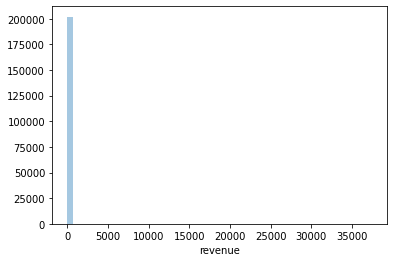

In [ ]:
sns.distplot(ab_test[ab_test.testgroup == 'a'].revenue, kde=False)

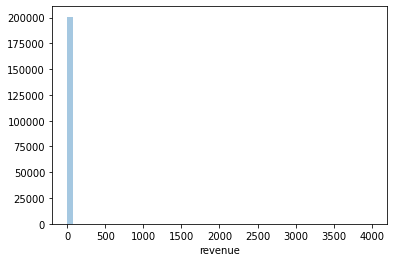

In [ ]:
sns.distplot(ab_test[ab_test.testgroup == 'b'].revenue, kde=False)

In [ ]:
# Гистограммы без выбросов

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


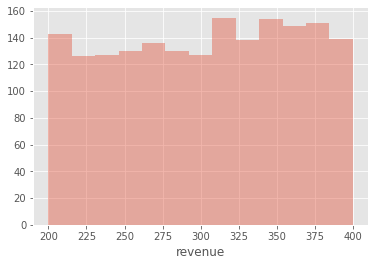

In [ ]:
sns.distplot(ab_test.query('testgroup == "a" and 0 != revenue < 30000').revenue, kde=False)

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


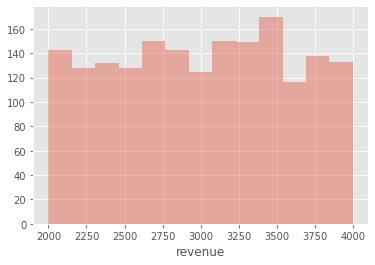

In [ ]:
sns.distplot(ab_test.query('testgroup == "b" and revenue != 0').revenue, kde=False)

In [ ]:
# Боксплот

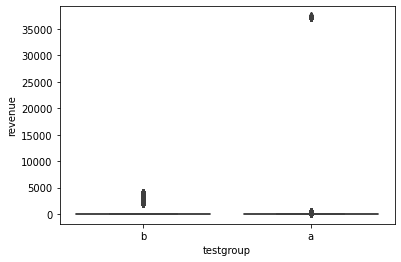

In [ ]:
sns.boxplot(x="testgroup", y="revenue", data=ab_test)

In [ ]:
# По графикам явно видно, что распределение ненормально
# в группах присутствуют заметные выбросы 

In [ ]:
# Так же провем распределение на нормальность при помощи теста Шапиро-Вилка

In [ ]:
stats.shapiro(ab_test.query('testgroup == "a"').revenue.sample(1000, random_state=17))

(0.06614720821380615, 0.0)

In [ ]:
stats.shapiro(ab_test.query('testgroup == "b"').revenue.sample(1000, random_state=17))

(0.06715953350067139, 0.0)

Распределения в обеих группах не являются нормальными т.к. p-value < 0.05.
Это значит, что для определения статистической значимости между контрольной и тестовой группами необходимо использовать критерий Манна-Уитни или бутстрап:

MannwhitneyuResult(statistic=20468349325.0, pvalue=0.03134850658037196)

Для дальнейшего анализа воспользуемся методом бутстрап. 
Для принятия решения проанализируем разницу между конверсией и средним чеком в группах

In [20]:
def bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max(len(data_column_1), len(data_column_2))
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values 
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        boot_data.append(statistic([samples_1 - samples_2])) # применяем статистику

    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.median(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.median(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

In [ ]:
  # Конверсия

In [15]:
  # Для дальнейшего расчета создадим новый столбец с булевыми значениями
ab_test['fact_of_payment'] = np.where(ab_test.revenue>0, 1, 0)

In [16]:
conversion_ab_test = ab_test.groupby(['user_id', 'testgroup'], as_index=False).agg({'revenue' : 'count','fact_of_payment' : 'sum'})

In [17]:
  # Переименуем столбцы
conversion_ab_test = conversion_ab_test.rename(columns = {'revenue' : 'visits', 'fact_of_payment' : 'amount_of_purchase'})

In [18]:
conversion_ab_test['conversion'] = conversion_ab_test['amount_of_purchase']/conversion_ab_test['visits']*100

  0%|          | 0/1000 [00:00<?, ?it/s]

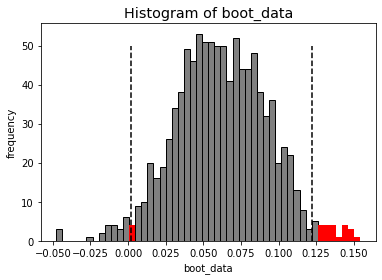

In [21]:
conversion_control = conversion_ab_test.query('testgroup == "a"').conversion
conversion_test = conversion_ab_test.query('testgroup == "b"').conversion
conversion = bootstrap (conversion_control, conversion_test)

In [ ]:
conversion['quants']

,0
0.025,0.003947
0.975,0.121381


In [ ]:
conversion['p_value']

0.03208413045850024

In [ ]:
# критерий Манна-Уитни
stats.mannwhitneyu(conversion_control, conversion_test)

MannwhitneyuResult(statistic=20466831320.0, pvalue=0.017514378449579253)

In [ ]:
Исходя из p-value бутстрап, можно сделать вывод,
что при расчете разниц между средними мы получили статистически значимые различия.
Так же это видно и на графике распределения. 0 не попадает в доверительный интервал,
что говорит о значимых различиях между контрольной и тестовой группами.
Критерий Манна-Уитни тоже показал стат значимую разницу конверсий, т.к. p-value < 0.05.

  0%|          | 0/1000 [00:00<?, ?it/s]

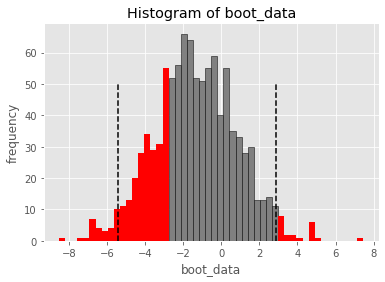

In [22]:
#ARPU
control_revenue = ab_test.query('testgroup == "a"').revenue
test_revenue = ab_test.query('testgroup == "b"').revenue
mean = bootstrap(control_revenue, test_revenue)

In [ ]:
mean['quants']

,0
0.025,-5.448247
0.975,2.867482


In [ ]:
mean['p_value']

0.5331634562494898

In [ ]:
# критерий Манна-Уитни
stats.mannwhitneyu(control_revenue, test_revenue)

MannwhitneyuResult(statistic=20468349325.0, pvalue=0.03134850658037196)

  0%|          | 0/1000 [00:00<?, ?it/s]

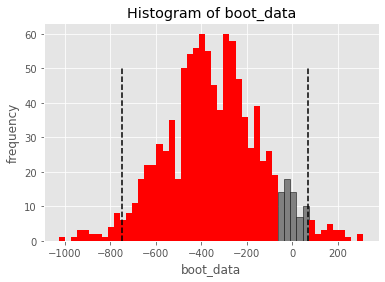

In [24]:
#ARPPU
mean = bootstrap(controle_group_customers, testgroup_customers)

In [25]:
mean['quants']

,0
0.025,-748.375765
0.975,71.692752


In [26]:
mean['p_value']

0.08940817590002978

Исходя из p-value бутстрап, можно сделать вывод,
что при расчете разниц между средними ARPU и ARPPU мы не получили статистически значимые различия.
Так же это видно и на графике распределения. 0 попадает в доверительный интервал,
что говорит о не значимых различиях между контрольной и тестовой группами.
Критерий Манна-Уитни же показал стат значимую разницу конверсий, т.к. p-value < 0.05. Возможно это происходит потому,
что критерий Манна-Уитни ранжирует значения и поэтому менее восприимчив к выбросам.

-        На данный момент видна статистически значимая разность конверсий между тестовой и контрольной группами.
-        И отсутствие таковой при сравнении выручки с учетом выбросов.
-        Т.е. контрольная группа является более предпочтительной. Но:

Проверим разницу между средними revenue убрав выбросы

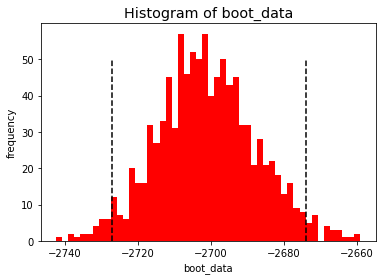

In [ ]:
control_revenue = ab_test.query('testgroup == "a" and 0 != revenue < 30000').revenue
test_revenue = ab_test.query('testgroup == "b" and revenue != 0').revenue
mean = bootstrap(control_revenue, test_revenue)

In [ ]:
mean['quants']

,0
0.025,-2727.211357
0.975,-2674.023033


In [ ]:
mean['p_value']

0.0

Убрав выбросы мы видим что существует значимая разница между выручкой в группах. И тестовая группа теперь выглядит более привлекательно.

In [ ]:
ab_test.query('testgroup == "a" and 0 != revenue < 30000').revenue.mean()

302.45817174515236

In [ ]:
ab_test.query('testgroup == "a" and 0 != revenue').revenue.sum()

5136189

In [ ]:
ab_test.query('testgroup == "b" and revenue != 0').revenue.mean()

3003.6581717451522

In [ ]:
ab_test.query('testgroup == "b" and revenue != 0').revenue.sum()

5421603

In [ ]:
ab_test.query('testgroup == "a"').revenue.mean()

25.413719736965806

In [ ]:
ab_test.query('testgroup == "b"').revenue.mean()

26.75128659327863

Так же из графиков выше и при отсечении выбросов видно, что выручка в группах отличается в разы.

# Выводы:
1) Исходя из разницы в выручке между группами, возможна ошибка в системе сплитования.

2) Cтатистически значима разность конверсий между тестовой и контрольной группами.(т.е. контрольная группа является более предпочтительной)

3) При отсечении выбросов стат. значима разница между выручкой. (предпочтительнее тестовая группа)

4) Результаты тестов и принятие решения сильно зависят от выбора метрик и подхода.

5) Если принимать решение исходя из того, что нам важнее ARPU и revenue, то предпочтительнее  набор акций тестовой группы.

# 6) Но из-за вероятности ошибки в сплит системе, наиболее подходящее решение ,на мой взгляд,  это провести эксперимент ещё раз, разобравшись с предполагаемой проблемой